#### Notebook 'Tempo'

In [1]:
# Carga de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from itertools import combinations
from collections import Counter
from pyvis.network import Network
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities


In [2]:
# Crear el DataFrame 'df_aspectos' con los aspectos y las variables asociadas
data_aspectos = {
    'aspecto': ['DROGAS_Y_CORRUPCIÓN'],
    'var_1': ['per603'],
    'var_2': ['per604'],
    'var_3': ['per605'],
    'var_4': ['per104'],
    'var_5': ['per304']
}
df_aspectos = pd.DataFrame(data_aspectos)
display(df_aspectos)
# cargar Analytical_Data
df_AD = pd.read_excel('data/Analytical_Data.xlsx')
display(df_AD.head())

,aspecto,var_1,var_2,var_3,var_4,var_5
0,DROGAS_Y_CORRUPCIÓN,per603,per604,per605,per104,per304


,Dominio,Nombre_Dominio,Variable_per,Detalle_Dominio
0,Domain_1,External Relations,per101,Foreign Special Relationships: Positive
1,Domain_1,External Relations,per102,Foreign Special Relationships: Negative
2,Domain_1,External Relations,per103,Anti-Imperialism
3,Domain_1,External Relations,per104,Military: Positive
4,Domain_1,External Relations,per105,Military: Negative


In [3]:
# Cargar datasets
df = pd.read_excel('./data/MP_ponderado_y_normalizado.xlsx')  # Dataset principal
print("Datos cargados:")
display(df.head())


Datos cargados:


,agno,countryname,per101,per102,per103,per104,per105,per106,per107,per108,...,per605,per606,per607,per608,per701,per702,per703,per704,per705,per706
0,1997,Albania,2.047208,0.000000,0.036283,3.521667,0.018391,0.037353,3.937380,1.288893,...,7.132017,0.801174,0.054652,0.0,0.755637,0.000000,8.333838,0.00000,0.500146,4.364612
1,2001,Albania,2.761724,0.000000,0.000000,3.182847,0.030726,0.027643,4.066757,1.676930,...,5.769535,0.645332,0.010242,0.0,0.255287,0.000000,13.905792,0.00000,0.626465,6.249323
2,1989,Argentina,0.000000,0.000000,4.643342,0.450962,0.832361,0.339836,2.970526,0.000000,...,1.456814,7.635007,0.328238,0.0,6.831962,0.000000,2.508315,0.00000,0.205098,2.063148
3,1995,Argentina,0.062411,0.020391,0.145034,0.893437,0.084040,1.121093,2.020915,1.690770,...,0.770212,2.022833,0.328013,0.0,2.962340,0.000000,1.517723,0.00000,0.250178,1.217375
4,1999,Argentina,0.198715,0.000000,0.601030,0.541209,0.018401,0.633114,3.594509,2.334666,...,4.473842,2.576219,0.958226,0.0,2.616696,0.092213,1.109202,0.04071,0.928451,1.506127


In [4]:
df.shape

(739, 58)

#### Paso 3: Funciones en pipeline de proceso

##### Filtrar y Normalizar

In [5]:
def preprocesar_periodo(df, desde, hasta):
    """
    Preprocesa el DataFrame para el período seleccionado.
    Combina registros de países con múltiples elecciones en el período y normaliza las variables.
    
    Parámetros:
    - df: DataFrame principal con datos de programas de gobierno.
    - desde: Año inicial del período.
    - hasta: Año final del período.

    Retorna:
    - df_periodo: DataFrame preprocesado con un registro por país en el período.
    """
    # Filtrar el DataFrame para el período
    df_periodo = df[(df['agno'] >= desde) & (df['agno'] <= hasta)]

    # Identificar países con más de una elección en el período
    duplicated_countries = df_periodo['countryname'].value_counts()
    duplicated_countries = duplicated_countries[duplicated_countries > 1]

    if not duplicated_countries.empty:
        #print("\nPaíses con más de una elección en el período:")
        for country in duplicated_countries.index:
            #print(f"\n{country}:")

            # Filtrar datos del país con duplicados
            country_data = df_periodo[df_periodo['countryname'] == country]

            # Imprimir los registros originales
            #print(f"Registros originales ({len(country_data)}):")
            #display(country_data)

            # Promediar las columnas `per` y conservar el primer año
            per_columns = [col for col in df_periodo.columns if col.startswith('per')]
            averaged_row = country_data[per_columns].mean().to_dict()
            averaged_row['agno'] = country_data['agno'].min()  # Primer año del período
            averaged_row['countryname'] = country

            # Imprimir los valores promedio
            #print("\nValores promediados:")
            # for key, value in averaged_row.items():
            #     if key in per_columns:  # Solo mostrar columnas 'per'
            #         print(f"{key}: {value:.4f}")

            # Eliminar los registros originales del dataframe filtrado
            df_periodo = df_periodo[df_periodo['countryname'] != country]

            # Agregar el registro promediado al dataframe
            df_periodo = pd.concat([df_periodo, pd.DataFrame([averaged_row])], ignore_index=True)

    else:
        print("\nNo hay países con más de una elección en el período.")

    # Verificar los resultados finales
    #print("\nDataframe ajustado (un registro por país en el período):")
    #display(df_periodo)

    return df_periodo


##### PCA y K-MEANS

In [6]:
def ejecutar_y_visualizar_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta, registros_codo):
    """
    Ejecuta K-MEANS, calcula el K óptimo usando el método del codo, aplica K-MEANS con 3 clústeres,
    y visualiza los resultados. Registra el óptimo de clústeres para cada período.

    Parámetros:
    - df_filtered: DataFrame filtrado y normalizado.
    - variables: Lista de variables 'per' a incluir en el análisis.
    - aspecto_filtro: Aspecto analizado (str).
    - desde: Año inicial del período.
    - hasta: Año final del período.
    - registros_codo: DataFrame para registrar el K óptimo por período.

    Retorna:
    - kmeans: Objeto K-MEANS ajustado.
    """

    # Paso 1: Extraer las variables numéricas
    X = df_filtered[variables]
    
    # Validar si hay suficientes muestras
    n_samples = X.shape[0]
    if n_samples < 3:  # Al menos 3 muestras para K-MEANS con 3 clústeres
        print(f"Período {desde}-{hasta}: No hay suficientes datos para clustering. Muestras: {n_samples}")
        registros_codo.append({'Periodo': f"{desde}-{hasta}", 'K_Optimo': None})
        return None

    # Paso 2: Método del codo para determinar el número óptimo de clústeres
    wcss = []  # Suma de los cuadrados dentro del cluster
    K = range(1, min(11, n_samples + 1))  # Asegurar que K no exceda el número de muestras

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    # Calcular el k óptimo usando la mayor caída relativa
    diffs = np.diff(wcss)
    k_optimo = np.argmin(diffs) + 2  # +2 porque el índice empieza en 0

    # Registrar el k óptimo para el período
    registros_codo.append({'Periodo': f"{desde}-{hasta}", 'K_Optimo': k_optimo})

    # Imprimir el k óptimo
    # print(f"K óptimo calculado mediante el método del codo: {k_optimo}")

    # # Visualizar el método del codo
    # plt.figure(figsize=(8, 5))
    # plt.plot(K, wcss, 'bx-', label="WCSS")
    # plt.axvline(x=k_optimo, color='red', linestyle='--', label=f"K óptimo = {k_optimo}")
    # plt.xlabel('Número de clusters (K)')
    # plt.ylabel('Suma de los cuadrados dentro del cluster (WCSS)')
    # plt.title(f'Método del codo para K óptimo\nAspecto: {aspecto_filtro} | Período: {desde}-{hasta}')
    # plt.grid(color='lightgray', linestyle='--', linewidth=0.5)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    # Paso 3: Aplicar K-MEANS con 3 clústeres (o menos si hay pocas muestras)
    optimal_k = min(3, n_samples)  # Ajustar el número de clústeres si hay pocas muestras
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    df_filtered['Cluster'] = kmeans.fit_predict(X)

    # Paso 4: Imprimir los países en cada clúster
    for cluster in range(optimal_k):
        paises_cluster = df_filtered[df_filtered['Cluster'] == cluster]['countryname'].tolist()
        print(f"Cluster {cluster}: {', '.join(paises_cluster)}")

    return kmeans


##### Matriz de coincidencias

In [7]:
def construir_matriz_coincidencias(resultados_temporales):
    coincidencias = Counter()
    for clusters in resultados_temporales.values():
        for cluster in clusters.values():
            for pair in combinations(sorted(cluster), 2):
                coincidencias[pair] += 1

    # Convertir a matriz
    paises = sorted(set([p for pair in coincidencias.keys() for p in pair]))
    coincidence_matrix = pd.DataFrame(0, index=paises, columns=paises)

    for (p1, p2), count in coincidencias.items():
        coincidence_matrix.loc[p1, p2] = count
        coincidence_matrix.loc[p2, p1] = count

    return coincidence_matrix


#### Grafo de Trayectorias temporales

#### Gráfico de coincidencias (con un cierto mínimo)

In [8]:
# LOUVAIN
from pyvis.network import Network
import networkx as nx
from community import community_louvain  # Librería para Louvain

def grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10):
    """
    Crea un grafo interactivo mejorado a partir de la matriz de coincidencias,
    filtrando conexiones con menos de `min_coincidencias` coincidencias.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para mostrar una conexión.
    """
    # Crear el grafo de NetworkX
    G = nx.Graph()
    for i, row in coincidence_matrix.iterrows():
        for j, value in row.items():
            if value >= min_coincidencias:  # Filtrar por número mínimo de coincidencias
                G.add_edge(i, j, weight=value)  # Añadir peso correctamente

    # Detectar comunidades usando el algoritmo Louvain
    partition = community_louvain.best_partition(G)
    communities = {}
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)

    # Crear un grafo interactivo con PyVis
    net = Network(notebook=True, height="750px", width="100%", cdn_resources="remote")
    net.from_nx(G)

    # Configurar físicas para deshabilitarlas
    net.set_options("""
    var options = {
      "physics": {
        "enabled": false
      }
    }
    """)

    # Ajustar nodos y aristas
    for node in net.nodes:
        # Color del nodo según la comunidad detectada
        community = partition[node["id"]]
        node["color"] = f"hsl({community * 360 / len(communities)}, 70%, 70%)"
        
        # Tamaño del nodo según el grado
        node["value"] = len(list(G.neighbors(node["id"])))

    for edge in net.edges:
        # Grosor de las aristas según el peso
        from_node = edge["from"]
        to_node = edge["to"]
        if G.has_edge(from_node, to_node):
            edge["width"] = G[from_node][to_node].get("weight", 1)  # Usar 1 como valor por defecto

    # Calcular métricas de centralidad
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Mostrar las métricas en la terminal
    print("\nCentralidad de Grado (Top 5):")
    for node, centrality in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    print("\nCentralidad de Betweenness (Top 5):")
    for node, centrality in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    # Guardar el grafo en un archivo HTML
    output_file = "LOUVAIN_grafo_coincidencias_filtrado.html"
    net.show(output_file)
    print(f"Grafo guardado como '{output_file}'. Ábrelo para visualizar.")


#### Heatmap de coincidencias (con un cierto mínimo)

In [9]:
def heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm"):
    """
    Genera un heatmap mostrando solo los países que tienen coincidencias >= min_coincidencias,
    con las celdas que cumplen mostrando el número real de coincidencias y las que no cumplen en blanco.
    
    Parámetros:
    - coincidence_matrix: Matriz de coincidencias entre países.
    - min_coincidencias: Número mínimo de coincidencias para considerar un enlace.
    - cmap: Paleta de colores para el heatmap.
    """
    # Crear una copia de la matriz para no modificar el original
    filtered_matrix = coincidence_matrix.copy()
    
    # Filtrar países que cumplen el umbral en filas o columnas
    relevant_countries = (filtered_matrix >= min_coincidencias).sum(axis=1) > 0
    filtered_matrix = filtered_matrix.loc[relevant_countries, relevant_countries]
    
    # Crear una máscara para ocultar valores por debajo del umbral
    mask = filtered_matrix < min_coincidencias
    
    # Verificar si quedan datos para graficar
    if filtered_matrix.empty:
        print(f"No hay países con coincidencias >= {min_coincidencias}.")
        return
    
    # Crear el heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        filtered_matrix,
        annot=filtered_matrix.where(~mask).round(0),  # Mostrar valores enteros redondeados
        fmt="g",  # Usar formato general (float/int)
        cmap=cmap,
        linewidths=0.5,  # Añadir líneas de la grilla
        linecolor="gray",
        cbar_kws={"label": "Número de Coincidencias"},
        mask=mask  # Aplicar la máscara
    )
    plt.title(f"Heatmap de Coincidencias Filtrado (≥ {min_coincidencias})\nDrogas y Corrupción (1949 a 2022)", fontsize=14)
    plt.xlabel("País")
    plt.ylabel("País")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()


#### Ejecución para Múltiples Períodos

Períodos generados:
[(2019, 2022), (2015, 2018), (2011, 2014), (2007, 2010), (2003, 2006), (1999, 2002), (1995, 1998), (1991, 1994), (1987, 1990), (1983, 1986), (1979, 1982), (1975, 1978), (1971, 1974), (1967, 1970), (1963, 1966), (1959, 1962), (1955, 1958), (1951, 1954)]

Procesando período: 2019-2022


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Argentina, Austria, Belgium, Brazil, Canada, Chile, Denmark, Finland, Germany, Greece, Iceland, Lithuania, Moldova, Montenegro, Netherlands, New Zealand, Panama, Portugal, South Africa, South Korea, Spain, United Kingdom, Australia
Cluster 1: Sweden
Cluster 2: Armenia, Estonia, Georgia, Ukraine, United States

Procesando período: 2015-2018


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Australia, Austria, Canada, Czech Republic, Estonia, Finland, Georgia, Japan, Latvia, Lithuania, Netherlands, Poland, United States, Armenia, United Kingdom
Cluster 1: Croatia, Cyprus, Germany, Hungary, Iceland, Ireland, Israel, New Zealand, Norway, Portugal, Romania, Serbia, Slovenia, South Korea, Spain, Switzerland, Turkey
Cluster 2: Argentina, Brazil, Bulgaria, Chile, Denmark, Dominican Republic, France, Italy, Slovakia, Sweden, Mexico

Procesando período: 2011-2014


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Belgium, Bulgaria, Canada, Chile, Colombia, Czech Republic, Estonia, France, Lithuania, Netherlands, Norway, Panama, Peru, Portugal, Russia, Slovakia, South Africa, Sweden, Turkey
Cluster 1: Armenia, Georgia, Poland, United States, Latvia, Ukraine
Cluster 2: Australia, Austria, Bolivia, Bosnia-Herzegovina, Brazil, Costa Rica, Cyprus, Denmark, Dominican Republic, Finland, Germany, Greece, Hungary, Iceland, Italy, Japan, Luxembourg, Moldova, Montenegro, Romania, Serbia, South Korea, Spain, Uruguay, Argentina, Slovenia, New Zealand

Procesando período: 2007-2010


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Bolivia, Bosnia-Herzegovina, Brazil, Chile, Denmark, Ecuador, Finland, France, Germany, Greece, Japan, Luxembourg, Montenegro, New Zealand, Panama, Slovenia, South Korea, Sweden, Serbia, Australia, Moldova, Iceland
Cluster 1: Argentina, Austria, Belgium, Bulgaria, Canada, Colombia, Costa Rica, Czech Republic, Hungary, Ireland, Italy, Lithuania, Netherlands, Portugal, Romania, Slovakia, South Africa, Spain, Switzerland, Turkey
Cluster 2: Armenia, Estonia, Georgia, Latvia, North Macedonia, Norway, Poland, Russia, Ukraine, United Kingdom, United States

Procesando período: 2003-2006


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Argentina, Armenia, Australia, Austria, Bosnia-Herzegovina, Brazil, Chile, Colombia, Costa Rica, Cyprus, Denmark, Finland, Germany, Greece, Iceland, Israel, Latvia, Lithuania, Luxembourg, Mexico, Moldova, Montenegro, Norway, Poland, Romania, Russia, Slovenia, South Korea, Spain, Sweden, Switzerland, Ukraine, Japan, Georgia
Cluster 1: Belgium, Czech Republic, Estonia, New Zealand, Slovakia, South Africa, United Kingdom, United States, Netherlands, Canada
Cluster 2: Panama

Procesando período: 1999-2002


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Albania, Azerbaijan, Belgium, Canada, Czech Republic, Denmark, Estonia, France, Latvia, Mexico, Netherlands, Poland, Romania, Russia, Slovakia, South Africa, Ukraine, United Kingdom, United States
Cluster 1: Israel
Cluster 2: Argentina, Armenia, Australia, Brazil, Bulgaria, Chile, Colombia, Costa Rica, Cyprus, Finland, Germany, Greece, Iceland, Ireland, Japan, Lithuania, Luxembourg, Moldova, Norway, Panama, Serbia, Slovenia, South Korea, Spain, Sweden, Switzerland, Austria, Turkey, Bosnia-Herzegovina, New Zealand

Procesando período: 1995-1998


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Albania, Armenia, Azerbaijan, Denmark, France, Georgia, Germany, Hungary, Ireland, Netherlands, New Zealand, Poland, Slovakia, Slovenia, Switzerland, Ukraine, United Kingdom, United States, Latvia, Czech Republic
Cluster 1: Argentina, Austria, Belarus, Belgium, Bosnia-Herzegovina, Brazil, Canada, Costa Rica, Finland, Greece, Iceland, Japan, Mexico, Moldova, North Macedonia, Norway, Romania, South Korea, Spain, Sweden, Turkey, Malta, Australia
Cluster 2: Israel

Procesando período: 1991-1994


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Austria, Canada, Chile, Costa Rica, Denmark, Germany, Ireland, Latvia, Netherlands, New Zealand, Russia, South Africa, United Kingdom, United States
Cluster 1: Australia, Belgium, Brazil, Finland, France, Greece, Hungary, Iceland, Israel, Italy, Luxembourg, Moldova, Montenegro, Norway, Panama, Poland, Romania, Slovenia, South Korea, Spain, Switzerland, Turkey, Sweden, Mexico
Cluster 2: Japan

Procesando período: 1987-1990


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Israel, United States
Cluster 1: Argentina, Austria, Belgium, Bosnia-Herzegovina, Bulgaria, Canada, Chile, Costa Rica, Finland, France, Georgia, Hungary, Iceland, Italy, Luxembourg, Mexico, Netherlands, North Macedonia, Norway, Portugal, Serbia, Slovakia, Spain, Sweden, Switzerland, Turkey, United Kingdom, Denmark, Australia, Ireland, New Zealand, Greece, Germany
Cluster 2: Japan

Procesando período: 1983-1986


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Belgium, Canada, Denmark, Finland, France, Germany, Greece, Iceland, Italy, Luxembourg, Mexico, Netherlands, New Zealand, Norway, Spain, Sweden, Switzerland, Turkey, United Kingdom, United States, Australia, Austria, Portugal
Cluster 1: Israel
Cluster 2: Japan

Procesando período: 1979-1982


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Australia, Austria, Belgium, Finland, France, Germany, Greece, Iceland, Italy, Luxembourg, Mexico, New Zealand, Norway, Switzerland, United Kingdom, Canada, Denmark, Sweden, Spain, Portugal, Ireland, Netherlands
Cluster 1: Japan
Cluster 2: Israel, United States

Procesando período: 1975-1978


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Japan
Cluster 1: Austria, Finland, France, Germany, Greece, Iceland, Ireland, Italy, Netherlands, Norway, Spain, Sri Lanka, Sweden, Switzerland, Turkey, United States, Australia, Belgium, Denmark, Portugal, New Zealand
Cluster 2: Israel

Procesando período: 1971-1974


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Austria, Finland, France, Greece, Ireland, Italy, Japan, Luxembourg, Mexico, New Zealand, Norway, Sweden, Switzerland, Turkey, United Kingdom, Australia, Belgium, Canada, Denmark, Iceland, Netherlands
Cluster 1: Israel
Cluster 2: Germany, Northern Ireland, United States

Procesando período: 1967-1970


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Australia, Israel
Cluster 1: Belgium, Canada, Denmark, Finland, Iceland, Ireland, Italy, Luxembourg, Mexico, Netherlands, Northern Ireland, Norway, Sri Lanka, Switzerland, Turkey, Sweden, France
Cluster 2: Austria, Germany, New Zealand, United Kingdom, United States, Japan

Procesando período: 1963-1966


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Austria, Belgium, Finland, Germany, Iceland, Ireland, Israel, Italy, Japan, Luxembourg, Mexico, Netherlands, Norway, Sweden, Switzerland, Turkey, United Kingdom, Canada, Denmark, New Zealand
Cluster 1: Northern Ireland, Sri Lanka
Cluster 2: United States, Australia

Procesando período: 1959-1962


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Australia, Belgium, Canada, Denmark, Finland, France, Iceland, Ireland, Mexico, New Zealand, Northern Ireland, Sri Lanka, Sweden, Turkey, United Kingdom, Austria
Cluster 1: Israel
Cluster 2: Germany, Japan, Luxembourg, Netherlands, Norway, Switzerland, United States

Procesando período: 1955-1958


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Denmark, Germany, Switzerland, United Kingdom, United States, Australia
Cluster 1: Austria, Belgium, Finland, Iceland, Ireland, Italy, New Zealand, Northern Ireland, Norway, Sri Lanka, Turkey, Canada, France, Sweden, Mexico
Cluster 2: Israel, Netherlands

Procesando período: 1951-1954


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Cluster 0: Denmark, France, Israel, Norway, Sweden, Switzerland, United Kingdom, United States, Australia
Cluster 1: Belgium, Netherlands, Sri Lanka, Luxembourg
Cluster 2: Austria, Canada, Germany, Iceland, Italy, Mexico, Northern Ireland, Turkey, Finland, New Zealand, Ireland


,Periodo,K_Optimo
0,2019-2022,2
1,2015-2018,2
2,2011-2014,2
3,2007-2010,2
4,2003-2006,2
5,1999-2002,2
6,1995-1998,2
7,1991-1994,2
8,1987-1990,2
9,1983-1986,2


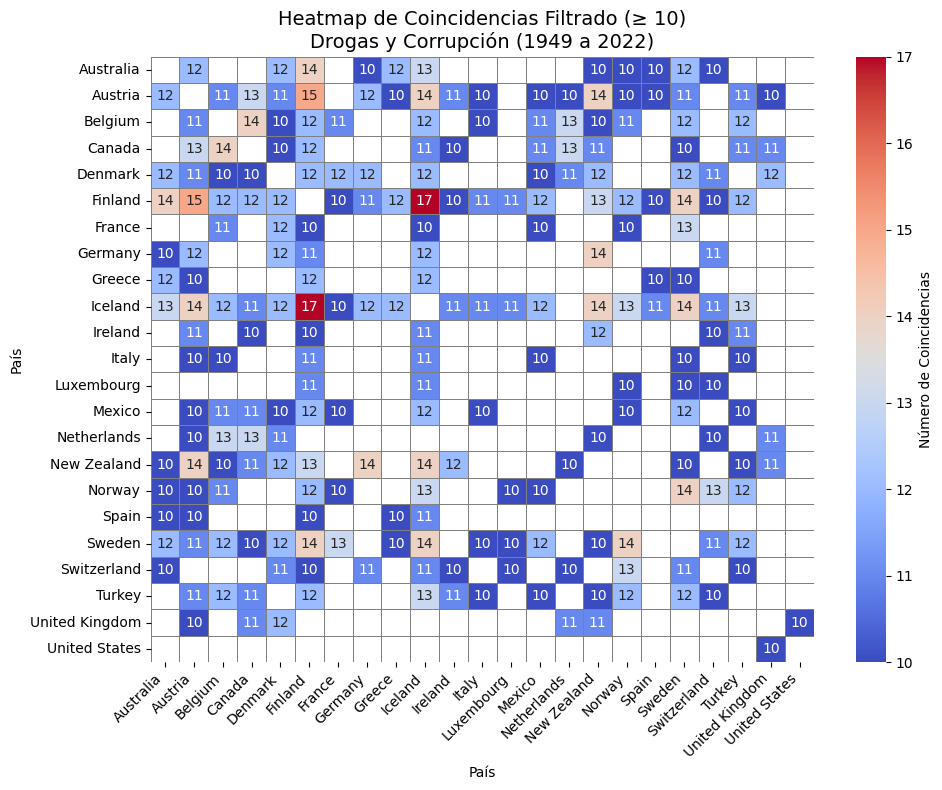

In [10]:
# Parámetros para la generación de períodos
primer_año = 1949
último_año = 2022
lapso = 4  # Duración de cada período en años

# Generar períodos en reversa
periodos = []
año_fin = último_año

while True:
    año_inicio = año_fin - lapso + 1
    if año_inicio < primer_año:  # Si el inicio del período es menor que el primer año, detener
        break
    periodos.append((año_inicio, año_fin))
    año_fin = año_inicio - 1

# Mostrar los períodos generados
print("Períodos generados:")
print(periodos)


# Aspecto y variables de análisis
aspecto_filtro = 'DROGAS_Y_CORRUPCIÓN'
variables = df_aspectos[df_aspectos['aspecto'] == aspecto_filtro][
    ['var_1', 'var_2', 'var_3', 'var_4', 'var_5']
].dropna().values.flatten()

# Diccionario para almacenar resultados por período
resultados_temporales = {}
registros_codo = []

# Iterar sobre los períodos y ejecutar K-MEANS
for desde, hasta in periodos:
    print(f"\nProcesando período: {desde}-{hasta}")
    
    # Preprocesar y normalizar datos para el período
    df_periodo = preprocesar_periodo(df, desde, hasta)  # Filtrar datos para el período
    df_filtered = df_periodo.copy()  # Usar copia directa o normalización si es necesario
    
    # Ejecutar K-MEANS y registrar el K óptimo
    kmeans = ejecutar_y_visualizar_kmeans(df_filtered, variables, aspecto_filtro, desde, hasta, registros_codo)
    
    # Guardar resultados en el diccionario
    resultados_temporales[(desde, hasta)] = {
        f"Cluster {i}": df_filtered[df_filtered['Cluster'] == i]['countryname'].tolist()
        for i in range(3)  # Ajusta según el número de clusters definido
    }

df_codo = pd.DataFrame(registros_codo)
display(df_codo)
# Construir y visualizar la matriz de coincidencias
coincidence_matrix = construir_matriz_coincidencias(resultados_temporales)

# Visualizar el grafo de coincidencias filtrado
#grafo_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10)

# Visualizar el heatmap con un umbral
heatmap_coincidencias_filtrado(coincidence_matrix, min_coincidencias=10, cmap="coolwarm")


#### Analicemos la calidad de los cluster con diferentes métodos. 
* ##### Silhouette Score: Medida de cohesión del cluster y de separación entre clusters.
*       * El Silhouette Score es particularmente útil porque mide:
*       *       * Qué tan cerca están las muestras dentro de un clúster.
*       *       * Qué tan separadas están las muestras de otros clústeres.
*       * Dado que los datos son proporciones y la suma es constante (1), el Silhouette Score es una buena elección porque no se ve afectado por la escala absoluta de los valores. Se basa en distancias relativas y funciona bien con proporciones.

* ##### Calinski-Harabasz: Relación entre dispersión intra-clúster e inter-clúster.
*       * El Calinski-Harabasz Index mide la dispersión dentro de los clústeres en relación con la separación entre los clústeres. Dado que tus datos son proporciones, esta métrica también es útil porque:
*       * Penaliza los clústeres que son demasiado dispersos.
*       * Prefiere configuraciones de clústeres compactos y bien separados.
*       * Ventajas:
*       *       * Considera tanto la separación como la cohesión.
*       *       * Es escalable para datasets grandes.
*

* Davies-Bouldin: Promedio de relaciones dispersión/separación (menores valores son mejores).

#### Interpretación
* Silhouette Score:
        Busca el kk con el puntaje más alto. Si el puntaje cae significativamente de k=2k=2 a k=3k=3, podrías reconsiderar k=3k=3.

* Calinski-Harabasz Score:
        Valores más altos indican mejores clústeres. Evalúa si k=3k=3 tiene un puntaje razonable comparado con k=2k=2.

* Davies-Bouldin Score:
        Valores más bajos son mejores. Compara si k=3k=3 mantiene valores competitivos.

Evaluando calidad de clústeres para el período: 2019-2022


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 2015-2018
Evaluando calidad de clústeres para el período: 2011-2014


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 2007-2010
Evaluando calidad de clústeres para el período: 2003-2006


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 1999-2002
Evaluando calidad de clústeres para el período: 1995-1998


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 1991-1994


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 1987-1990


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Evaluando calidad de clústeres para el período: 1983-1986


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 1979-1982


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Evaluando calidad de clústeres para el período: 1975-1978


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 1971-1974


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 1967-1970


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 1963-1966


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 1959-1962


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Evaluando calidad de clústeres para el período: 1955-1958
Evaluando calidad de clústeres para el período: 1951-1954
Resultados de evaluación de clústeres:


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

,Periodo,K,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,2019-2022,2,0.343268,8.900818,1.320938
1,2019-2022,3,0.422952,11.366079,0.941111
2,2019-2022,4,0.392769,15.863029,0.536414
3,2019-2022,5,0.271396,19.181500,0.793708
4,2015-2018,2,0.263273,18.875235,1.353165
...,...,...,...,...,...
67,1955-1958,5,0.423121,21.530034,0.619442
68,1951-1954,2,0.307867,11.745343,1.226307
69,1951-1954,3,0.347197,14.635683,0.970622
70,1951-1954,4,0.328064,13.464159,0.875618


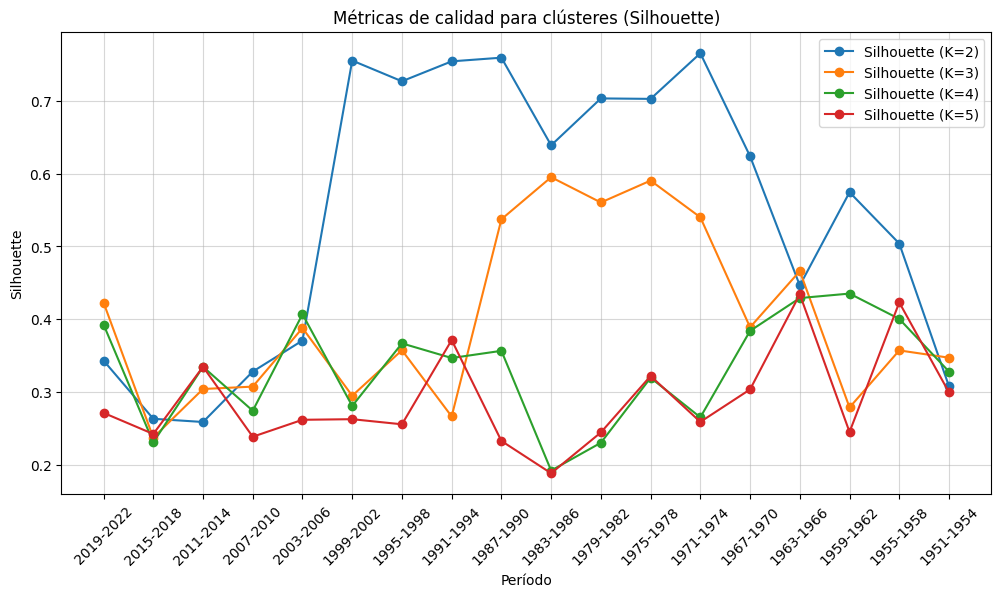

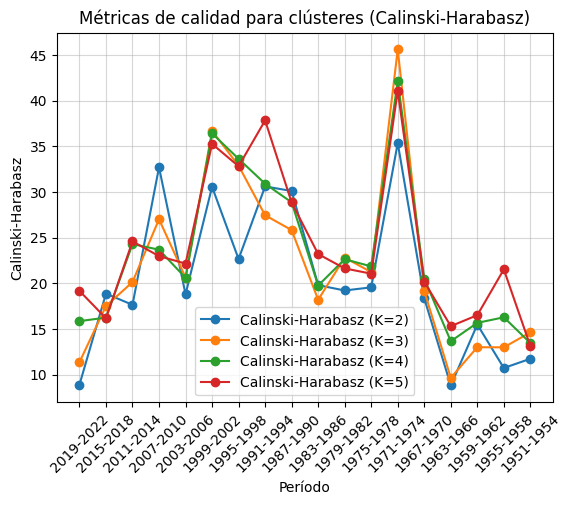

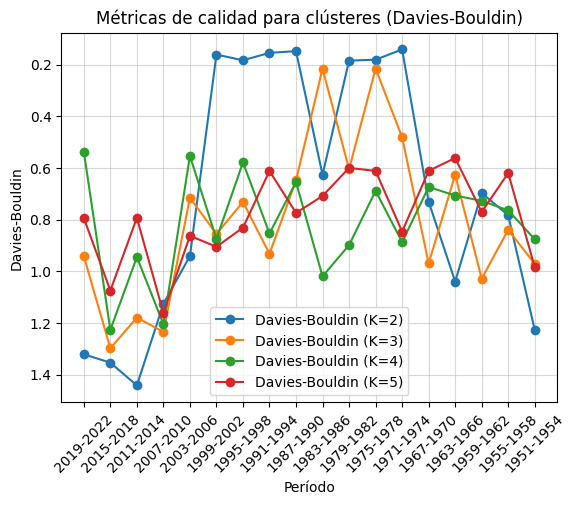

In [11]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Valores de K a evaluar
k_values = [2, 3, 4, 5]

# Lista para almacenar los resultados por período
calidad_clustering = []

# Evaluar la calidad de los clústeres para cada período
for desde, hasta in periodos:
    print(f"Evaluando calidad de clústeres para el período: {desde}-{hasta}")
    
    # Filtrar el DataFrame para el período
    df_periodo = preprocesar_periodo(df, desde, hasta)
    if df_periodo.shape[0] < 3:  # Omitir períodos con muy pocos datos
        print(f"Período {desde}-{hasta} tiene menos de 3 registros, no se evaluará.")
        continue
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(df_periodo[variables])
        
        # Calcular métricas
        silhouette = silhouette_score(df_periodo[variables], labels)
        calinski = calinski_harabasz_score(df_periodo[variables], labels)
        davies = davies_bouldin_score(df_periodo[variables], labels)
        
        # Guardar resultados
        calidad_clustering.append({
            'Periodo': f"{desde}-{hasta}",
            'K': k,
            'Silhouette': silhouette,
            'Calinski-Harabasz': calinski,
            'Davies-Bouldin': davies
        })

# Convertir los resultados a un DataFrame
df_calidad = pd.DataFrame(calidad_clustering)

# Mostrar los resultados
print("Resultados de evaluación de clústeres:")
display(df_calidad)

# Graficar las métricas
plt.figure(figsize=(12, 6))
for metric in ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']:
    for k in k_values:
        subset = df_calidad[df_calidad['K'] == k]
        plt.plot(subset['Periodo'], subset[metric], label=f"{metric} (K={k})", marker='o')
    plt.title(f'Métricas de calidad para clústeres ({metric})')
    plt.xlabel('Período')
    plt.ylabel(metric)
    if metric == 'Davies-Bouldin':
        plt.gca().invert_yaxis()  # Invertir para que menores valores sean mejores
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(alpha=0.5)
    plt.show()


#### Análisis de resultados de clustering:
* Usando SILHOUETTE como medidor de la calidad de los clusters, para el período 2000 en adelante, usaremos k=3 clusters. Para los anteriores a 2000, usaremos k=2 clusters.

#### Procesamos nuevamente con k=2 y k=3 

In [12]:
# Diccionario para almacenar resultados por período
resultados_temporales = []

for desde, hasta in periodos:
    print(f"\nProcesando período: {desde}-{hasta}")
    
    # Filtrar el DataFrame para el período actual
    df_periodo = preprocesar_periodo(df, desde, hasta)
    if df_periodo.shape[0] < 2:  # Omitir períodos con menos de 2 registros
        print(f"Período {desde}-{hasta} tiene menos de 2 registros, no se procesará.")
        continue
    
    # Decidir el número de clústeres
    if hasta <= 2002:
        num_clusters = 2
    else:
        num_clusters = 3
    print(f"Usando K={num_clusters} para el período {desde}-{hasta}")
    
    # Aplicar K-MEANS
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df_periodo['Cluster'] = kmeans.fit_predict(df_periodo[variables])
    
    # Guardar los resultados del período
    resultados_temporales.append({
        'Periodo': f"{desde}-{hasta}",
        'K': num_clusters,
        'Clusters': {
            f"Cluster {i}": df_periodo[df_periodo['Cluster'] == i]['countryname'].tolist()
            for i in range(num_clusters)
        }
    })

# Convertir los resultados a un DataFrame
df_resultados = pd.DataFrame(resultados_temporales)

# Mostrar los resultados
print("Resultados del análisis de clústeres:")
display(df_resultados)



Procesando período: 2019-2022
Usando K=3 para el período 2019-2022

Procesando período: 2015-2018
Usando K=3 para el período 2015-2018

Procesando período: 2011-2014
Usando K=3 para el período 2011-2014


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 2007-2010
Usando K=3 para el período 2007-2010

Procesando período: 2003-2006
Usando K=3 para el período 2003-2006

Procesando período: 1999-2002
Usando K=2 para el período 1999-2002

Procesando período: 1995-1998
Usando K=2 para el período 1995-1998

Procesando período: 1991-1994


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/

Usando K=2 para el período 1991-1994

Procesando período: 1987-1990
Usando K=2 para el período 1987-1990

Procesando período: 1983-1986
Usando K=2 para el período 1983-1986

Procesando período: 1979-1982
Usando K=2 para el período 1979-1982


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Procesando período: 1975-1978
Usando K=2 para el período 1975-1978

Procesando período: 1971-1974
Usando K=2 para el período 1971-1974

Procesando período: 1967-1970
Usando K=2 para el período 1967-1970

Procesando período: 1963-1966
Usando K=2 para el período 1963-1966


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/


Procesando período: 1959-1962
Usando K=2 para el período 1959-1962

Procesando período: 1955-1958
Usando K=2 para el período 1955-1958

Procesando período: 1951-1954
Usando K=2 para el período 1951-1954
Resultados del análisis de clústeres:


/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Applications/anaconda3/envs/DatascienceUDD/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Periodo,K,Clusters
0,2019-2022,3,"{'Cluster 0': ['Argentina', 'Austria', 'Belgiu..."
1,2015-2018,3,"{'Cluster 0': ['Australia', 'Austria', 'Canada..."
2,2011-2014,3,"{'Cluster 0': ['Belgium', 'Bulgaria', 'Canada'..."
3,2007-2010,3,"{'Cluster 0': ['Bolivia', 'Bosnia-Herzegovina'..."
4,2003-2006,3,"{'Cluster 0': ['Argentina', 'Armenia', 'Austra..."
5,1999-2002,2,"{'Cluster 0': ['Israel'], 'Cluster 1': ['Alban..."
6,1995-1998,2,"{'Cluster 0': ['Israel'], 'Cluster 1': ['Alban..."
7,1991-1994,2,"{'Cluster 0': ['Australia', 'Austria', 'Belgiu..."
8,1987-1990,2,"{'Cluster 0': ['Argentina', 'Austria', 'Belgiu..."
9,1983-1986,2,"{'Cluster 0': ['Belgium', 'Canada', 'Denmark',..."


#### Analicemos cuántas veces dos países coincidieron en un mismo cluster

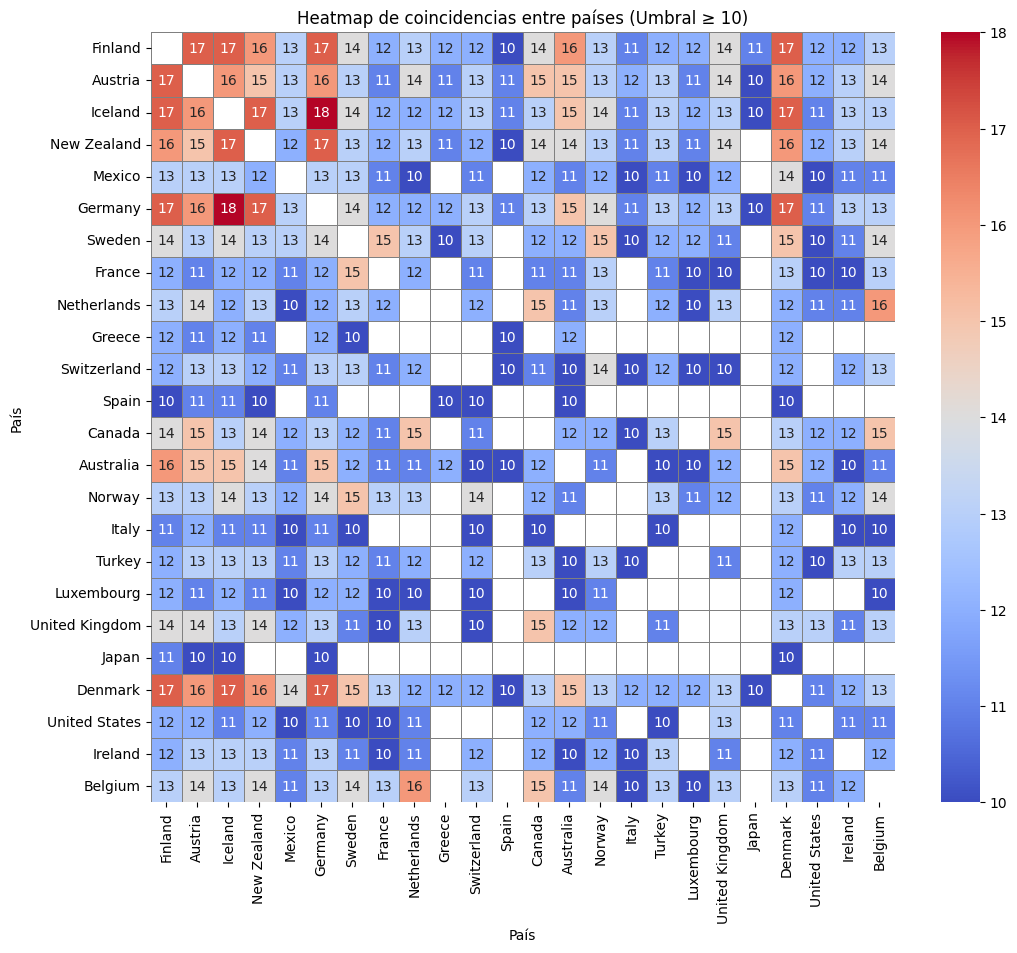

In [22]:
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Definir el umbral de coincidencias
umbral = 10

# Crear una lista de todas las coincidencias
coincidencias = []

for _, row in df_resultados.iterrows():
    clusters = row['Clusters']  # Diccionario de clústeres
    for cluster, countries in clusters.items():
        # Generar todas las combinaciones posibles de países en el clúster
        pairs = list(combinations(countries, 2))
        coincidencias.extend(pairs)

# Contar las coincidencias para cada par de países
df_coincidencias = pd.DataFrame(coincidencias, columns=['País 1', 'País 2'])
df_coincidencias['Coincidencia'] = 1

# Agrupar y contar las coincidencias
coincidence_matrix = df_coincidencias.groupby(['País 1', 'País 2'])['Coincidencia'].sum().unstack(fill_value=0)

# Crear una matriz cuadrada para asegurar simetría
countries = list(set(coincidence_matrix.index).union(coincidence_matrix.columns))
coincidence_matrix = coincidence_matrix.reindex(index=countries, columns=countries, fill_value=0)
coincidence_matrix = coincidence_matrix + coincidence_matrix.T

# Filtrar la matriz según el umbral
coincidence_matrix_filtered = coincidence_matrix[coincidence_matrix >= umbral].dropna(how='all', axis=0).dropna(how='all', axis=1)

# Convertir todos los valores de la matriz filtrada a enteros
coincidence_matrix_filtered = coincidence_matrix_filtered.fillna(0).astype(int)

# Crear una máscara para ocultar celdas con valor 0
mask = coincidence_matrix_filtered == 0

# Visualizar el heatmap con números en las celdas y grilla gris
plt.figure(figsize=(12, 10))
sns.heatmap(
    coincidence_matrix_filtered, 
    annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, linecolor="gray", cbar=True,
    mask=mask  # Aplicar la máscara para ocultar valores 0
)
plt.title(f"Heatmap de coincidencias entre países (Umbral ≥ {umbral})")
plt.xlabel("País")
plt.ylabel("País")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


#### HOLAAAAAAA

### <<<<<<<<<<<< NO USAR DESDE >>>>>>>>>>>>

### <<<<<<<<<<<< NO USAR HASTA >>>>>>>>>>>>

#### Análisis de la modularidad de la partición en comunidades según Greedy y según Louvain
* La modularidad es una métrica que mide la calidad de una partición en comunidades en un grafo. Una modularidad más alta indica una mejor partición, donde hay más enlaces dentro de las comunidades que los esperados por azar.
* Calcularemos la modularidad en NetworkX utilizando la función modularity() y las particiones generadas por Greedy y Louvain.

### Análisis de Comunidades: Drogas y Corrupción (1949-2022)

#### Variables analizadas:
- **`per605`**: *Law and Order* - Enfoques sobre el orden y la ley, incluyendo fortalecimiento de fuerzas policiales y aplicación de leyes.
- **`per304`**: *Political Corruption* - Referencias a la corrupción en instituciones políticas, su detección y castigo.
- **`per104`**: *Military-Positive* - Perspectiva positiva sobre el rol de las fuerzas armadas, incluyendo defensa y seguridad.
- **`per603`**: *Traditional Morality-Positive* - Promoción de valores tradicionales, frecuentemente relacionados con moralidad y religión.

### Descripción de las Comunidades

#### **Comunidad 0**: [Australia, Austria, Canada, France, Iceland, Israel]
- **Concepto General**: *Democracias avanzadas con políticas de seguridad moderadas y valores tradicionales.*
  - **Características comunes**:
    - Políticas relativamente equilibradas entre valores tradicionales y enfoques progresistas en temas como corrupción.
    - Énfasis en el mantenimiento del orden, pero sin una orientación militar marcada.
  - **Perspectiva según variables**:
    - **Alta relevancia en `per605` (Law and Order)**: Países con fuertes instituciones judiciales y políticas claras en seguridad pública.
    - **Baja relevancia en `per304` (Political Corruption)**: Contextos con menor énfasis en la corrupción, reflejo de sistemas políticos menos afectados por esta problemática.
    - **Moderado interés en `per603` (Traditional Morality)**: Promoción de valores tradicionales, pero no central en los programas presidenciales.

---

#### **Comunidad 1**: [Germany, Luxembourg, Netherlands, New Zealand, Spain, United Kingdom]
- **Concepto General**: *Naciones orientadas al progreso institucional y a la integridad política.*
  - **Características comunes**:
    - Sistemas políticos con políticas públicas sofisticadas, en especial en la lucha contra la corrupción.
    - Menor énfasis en valores tradicionales o militares.
  - **Perspectiva según variables**:
    - **Alta relevancia en `per304` (Political Corruption)**: Esfuerzos claros en la promoción de transparencia e integridad en la administración pública.
    - **Moderado interés en `per605` (Law and Order)**: Instituciones sólidas para el mantenimiento del orden, aunque no central.
    - **Baja relevancia en `per104` (Military-Positive)**: Ausencia de un enfoque militarista en los programas de gobierno.

---

#### **Comunidad 2**: [Belgium, Denmark, Mexico, Norway, Sweden, Switzerland]
- **Concepto General**: *Países con enfoques progresistas y un equilibrio entre seguridad y transparencia.*
  - **Características comunes**:
    - Contextos políticos diversos, desde democracias nórdicas hasta economías emergentes.
    - Énfasis equilibrado entre la promoción de valores tradicionales y el fortalecimiento institucional.
  - **Perspectiva según variables**:
    - **Moderada relevancia en `per605` (Law and Order)**: Seguridad pública como parte de los programas, pero sin un enfoque central.
    - **Alta relevancia en `per603` (Traditional Morality)**: Países que promueven valores tradicionales de manera significativa en sus programas.
    - **Moderado interés en `per304` (Political Corruption)**: Iniciativas claras para abordar la corrupción, aunque no tan central como en Comunidad 1.

---

### Resumen Comparativo de las Comunidades:
| Comunidad   | Concepto General                                                    | Variables predominantes                           |
|-------------|----------------------------------------------------------------------|--------------------------------------------------|
| Comunidad 0 | Democracias avanzadas con políticas moderadas y valores tradicionales. | `per605`: Ley y Orden                            |
| Comunidad 1 | Naciones con orientación progresista e integridad política.          | `per304`: Corrupción Política                    |
| Comunidad 2 | Países equilibrados entre progresismo y valores tradicionales.       | `per603`: Moralidad Tradicional; `per605`: Ley y Orden |

### Conclusión:
Cada comunidad agrupa países con contextos políticos y sociales específicos en torno a los temas seleccionados. Mientras la Comunidad 0 refleja estabilidad institucional y valores moderados, la Comunidad 1 enfatiza transparencia y progreso político. Por su parte, la Comunidad 2 destaca por un balance entre valores tradicionales y esfuerzos en seguridad y transparencia.